## Langgraph: Essay Writer

- A compact version of AI researcher

- The following is adapted from [LangChain's blog](https://blog.langchain.dev/langgraph/) and deeplearning.ai's short course.

- **What is LangGraph?**
  - LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence.
 

- **Some key concepts for langgraph:**
  - **Stategraph**: The state is being persisted throughout the agents lifecycle. It's a way of passing a dictionary around from chain to chain, or from chain to tools. We can update, overwrite and add to the dictionary.
  - **Nodes**: A node can be either a function or a runnable. You can have a variety of those nodes. Those are components you're going to wire them together. There are 2 main nodes we need for this:
    - The agent: responsible for deciding what (if any) actions to take.
    - A function to invoke tools: if the agent decides to take an action, this node will then execute that action.
  - **Edges**: Edges wire nodes together. There are a few different edges:
    - The starting edge
    - Normal edge
    - Conditional edge
  - **Compile**: Compile the graph into a runnable! This runnable exposes all the same method as LangChain runnables (`.invoke`, `.stream`, `.astream_log`, etc.), allowing it to be called in the same manner as a chain.

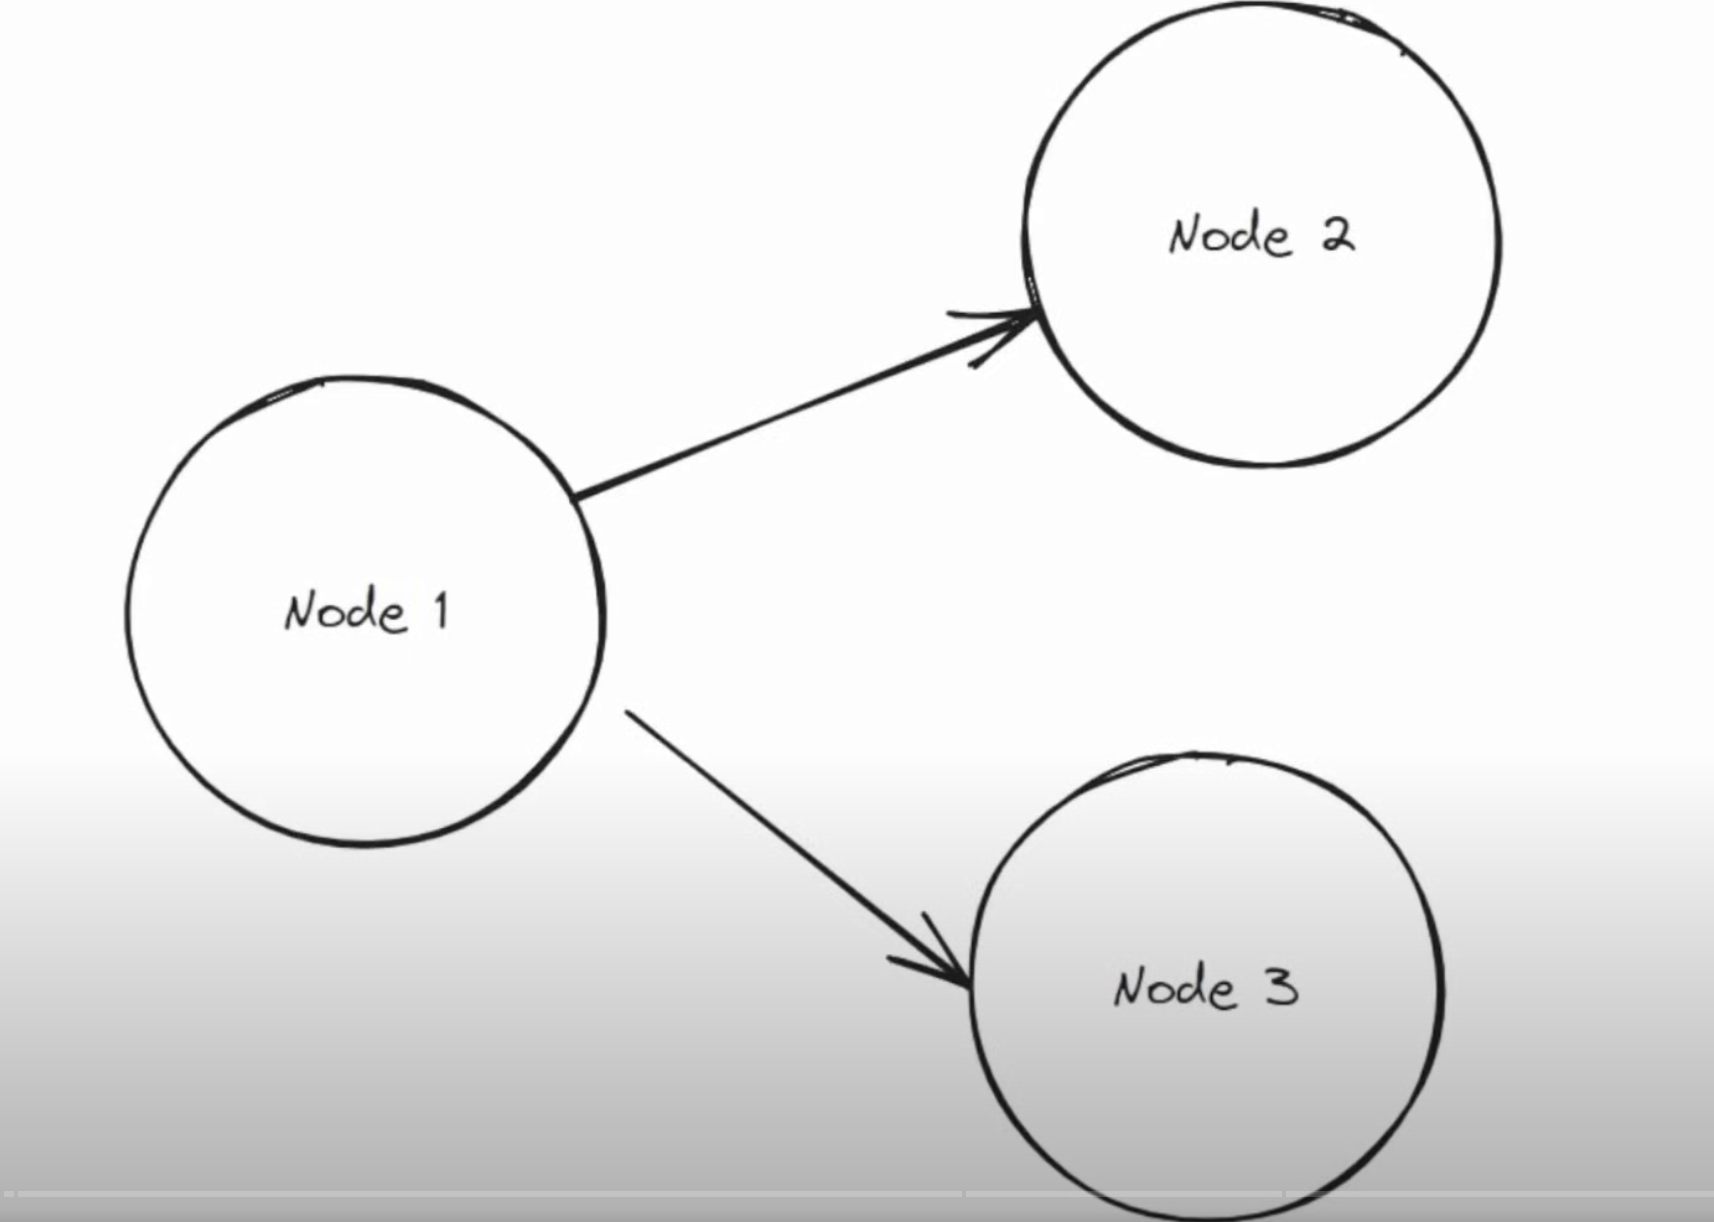

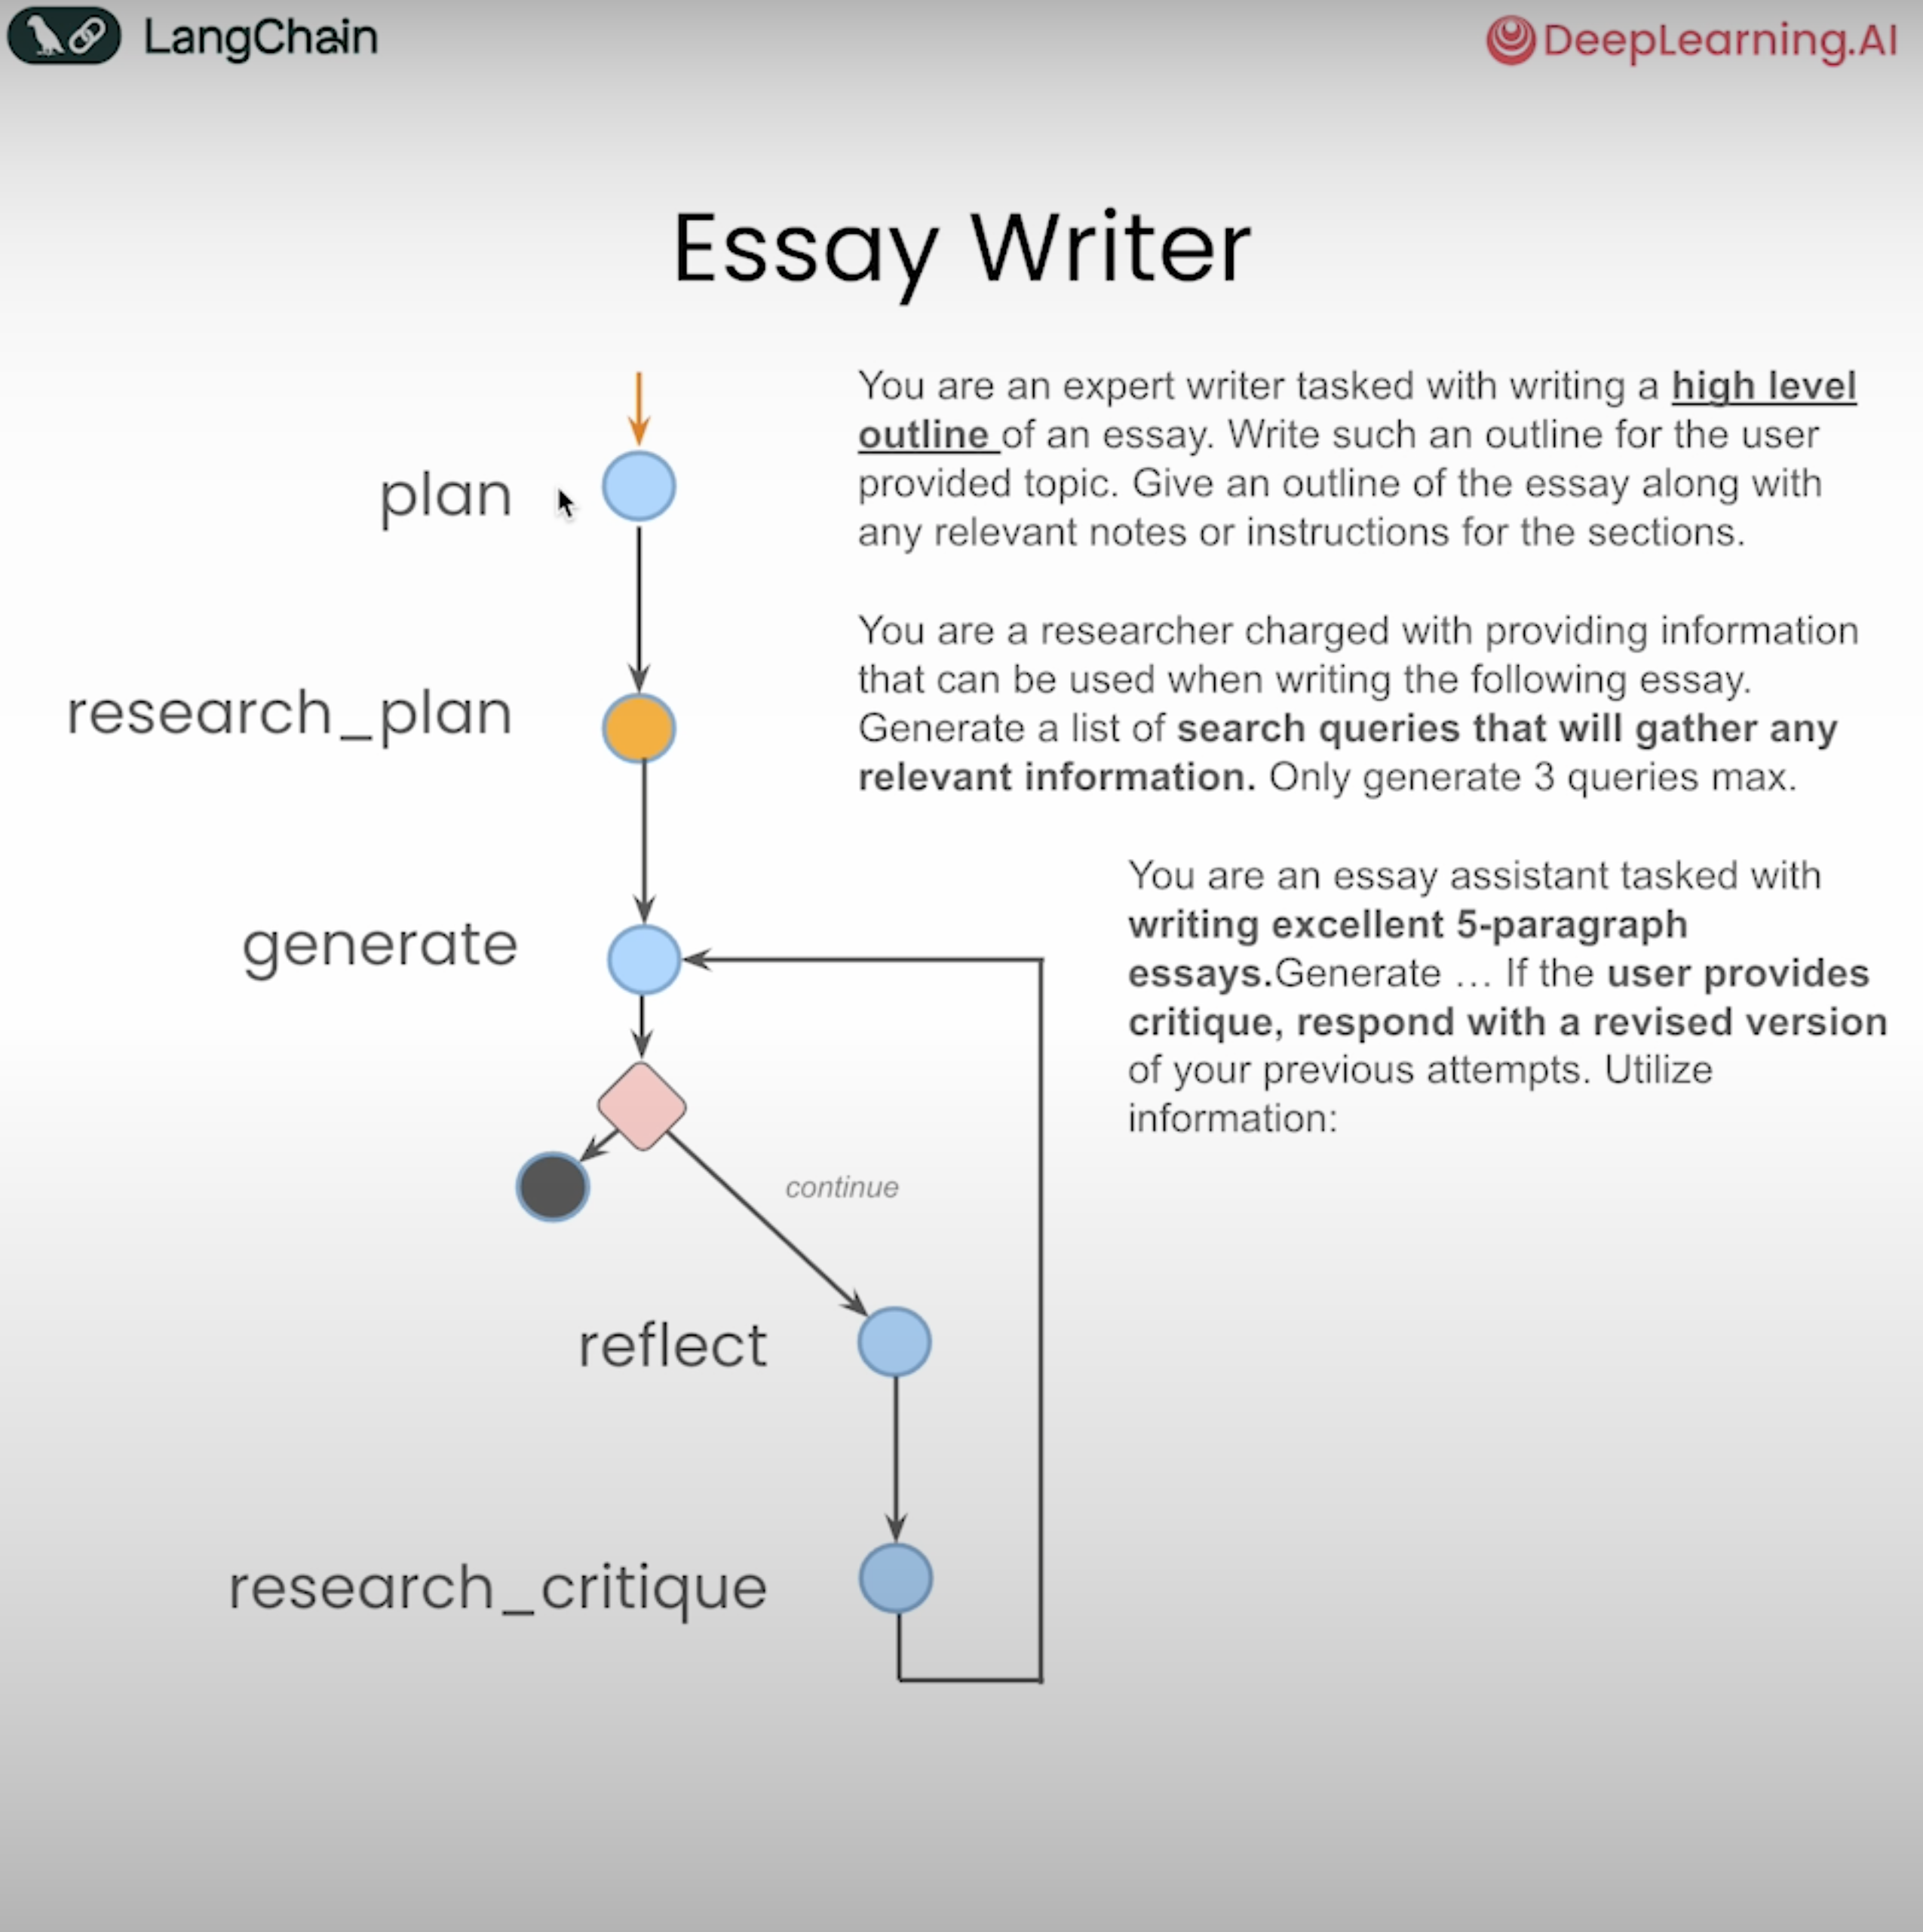

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver # in memory sqlite checkpointer
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
class AgentState(TypedDict):
    task: str # human input
    plan: str # planning agent generates
    draft: str
    critique: str # critique agent populates
    content: List[str] # the list of documents Tavily has researched and come back with
    revision_number: int # keep track of number of revisions
    max_revisions: int

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [12]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [13]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [14]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [15]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [16]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [17]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [18]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [19]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [20]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [21]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [22]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [23]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [24]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [25]:
builder = StateGraph(AgentState)

In [26]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [27]:
builder.set_entry_point("planner")

In [28]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [29]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [30]:
graph = builder.compile(checkpointer=memory)

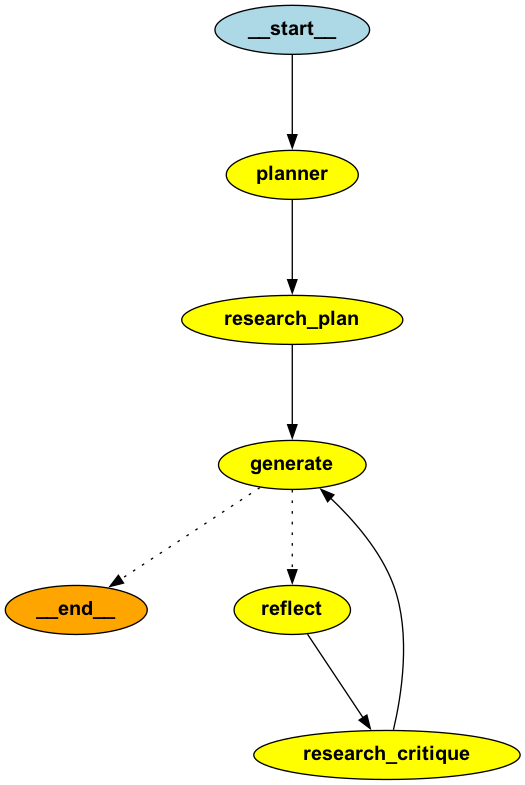

In [31]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [32]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIII. Langsmith\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack\n    B. Scalability\n    C. Security\n    D. Interoperability\n    E. Performance\n\nV. Conclusion\n    A. Recap of main differences between Langchain and Langsmith\n    B. Implications for future development and adoption\n    C. Final thoughts on the significance of these technologies\n\nNotes:\n- Ensure a clear and concise explanation of both Langchain and Langsmith.\n- Provide specific examples of use cases to illus

### Essay Writer Interface

In [33]:
import warnings
warnings.filterwarnings("ignore")

from helper import writer_gui, ewriter

In [34]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


### More info about Langgraph

- Check out langgraph's own example notebooks to see what other power tools you can create with langgraph: [link](https://github.com/langchain-ai/langgraph/tree/main/examples)
- Check out deeplearning.ai's 1 hour course [AI Agents in LangGraph](https://www.deeplearning.ai/short-courses/ai-agents-in-langgraph/) to learn more about langgraph.